# Quantile Random Forest (QRF) imputation

This notebook demonstrates how to use MicroImpute's QRF imputer to impute values using Quantile Random Forests. QRF is a powerful machine learning technique that extends traditional random forests to predict the entire conditional distribution of a target variable.

Currently, a single QRF object can only impute on one variable at a time.

## Setup and data preparation

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
import warnings

warnings.filterwarnings("ignore")

# Import MicroImpute tools
from microimpute.comparisons.data import preprocess_data
from microimpute.evaluations import *
from microimpute.models import QRF
from microimpute.config import QUANTILES

In [2]:
# Load the diabetes dataset
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# Display the first few rows of the dataset
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [3]:
# Define variables for the model
predictors = ["age", "sex", "bmi", "bp"]
imputed_variables = ["s1"]  # We'll impute 's1' (total serum cholesterol)

# Create a subset with only needed columns
diabetes_df = df[predictors + imputed_variables]

# Display summary statistics
diabetes_df.describe()

,age,sex,bmi,bp,s1
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01


In [4]:
# Split data into training and testing sets
X_train, X_test = preprocess_data(diabetes_df)

# Let's see how many records we have in each set
print(f"Training set size: {X_train.shape[0]} records")
print(f"Testing set size: {X_test.shape[0]} records")

Training set size: 353 records
Testing set size: 89 records


## Simulating missing data

For this example, we'll simulate missing data in our test set by removing the values we want to impute.

In [5]:
# Create a copy of the test set with missing values
X_test_missing = X_test.copy()

# Store the actual values for later comparison
actual_values = X_test_missing[imputed_variables].copy()

# Remove the values to be imputed
X_test_missing[imputed_variables] = np.nan

X_test_missing.head()

,age,sex,bmi,bp,s1
287,0.952161,-0.937474,-0.130325,-0.335978,NaN
211,1.943844,-0.937474,0.775037,0.459320,NaN
72,1.333577,1.064282,-0.085057,-0.263679,NaN
321,2.020127,-0.937474,1.091914,1.664559,NaN
73,0.265611,1.064282,-0.424568,-0.046779,NaN


## Training and using the QRF imputer

Now we'll train the QRF imputer and use it to impute the missing values in our test set.

In [8]:
# Initialize the QRF imputer with some custom parameters
# You can customize the random forest by passing additional parameters
qrf_imputer = QRF()

# Fit the model with our training data
# This trains a quantile random forest model
fitted_qrf_imputer = qrf_imputer.fit(
    X_train,
    predictors,
    imputed_variables,
    n_estimators=100,
    min_samples_leaf=5,
)

In [9]:
# Impute values in the test set
# This uses the trained QRF model to predict missing values at specified quantiles
imputed_values = fitted_qrf_imputer.predict(X_test_missing, QUANTILES)

# Display the first few imputed values at the median (0.5 quantile)
imputed_values[0.5].head()

,s1
0,-0.784218
1,0.862797
2,1.845227
3,1.036167
4,1.469592


## Evaluating the imputation results

Now let's compare the imputed values with the actual values to evaluate the performance of our imputer.

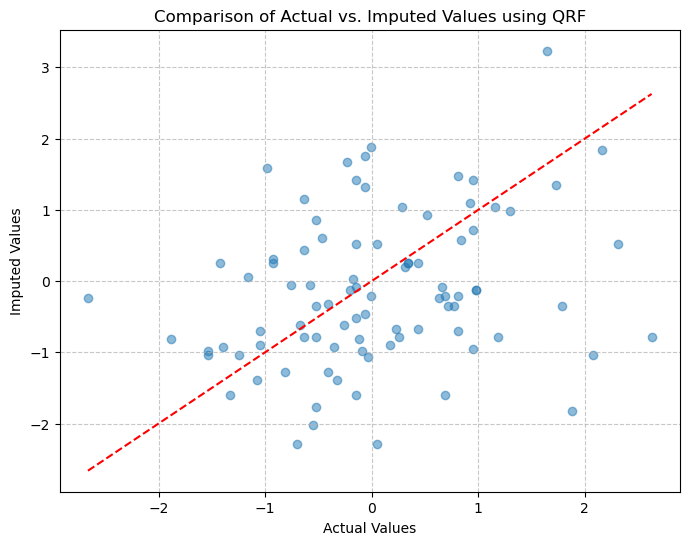

In [10]:
# Extract median predictions for evaluation
median_predictions = imputed_values[0.5]

# Create a scatter plot comparing actual vs. imputed values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, median_predictions, alpha=0.5)
plt.plot(
    [actual_values.min().min(), actual_values.max().max()],
    [actual_values.min().min(), actual_values.max().max()],
    "r--",
)
plt.xlabel("Actual Values")
plt.ylabel("Imputed Values")
plt.title("Comparison of Actual vs. Imputed Values using QRF")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

## Examining quantile predictions

QRF provides predictions at different quantiles, allowing us to capture the entire conditional distribution of the missing values.

In [11]:
# Compare predictions at different quantiles for the first 5 records
quantiles_to_show = QUANTILES
comparison_df = pd.DataFrame(index=range(5))

# Add actual values
comparison_df["Actual"] = actual_values.iloc[:5, 0].values

# Add quantile predictions
for q in quantiles_to_show:
    comparison_df[f"Q{int(q*100)}"] = imputed_values[q].iloc[:5, 0].values

comparison_df

,Actual,Q5,Q10,Q30,Q50,Q70,Q90,Q95
0,2.625393,-2.026704,-0.928693,0.487162,-0.784218,0.487162,1.585172,1.585172
1,-0.524163,-0.957588,0.024842,-0.957588,0.862797,0.978377,1.209537,2.683183
2,2.163073,-1.477699,-1.477699,-1.477699,1.845227,3.203293,3.203293,3.203293
3,1.151747,-0.957588,-0.957588,0.516057,1.036167,0.631637,1.209537,2.683183
4,0.805007,-2.026704,-2.026704,0.227107,1.469592,0.024842,0.660532,1.469592


## Visualizing prediction intervals

One of the advantages of QRF is that it can provide prediction intervals, which can help us understand the uncertainty in our imputed values.

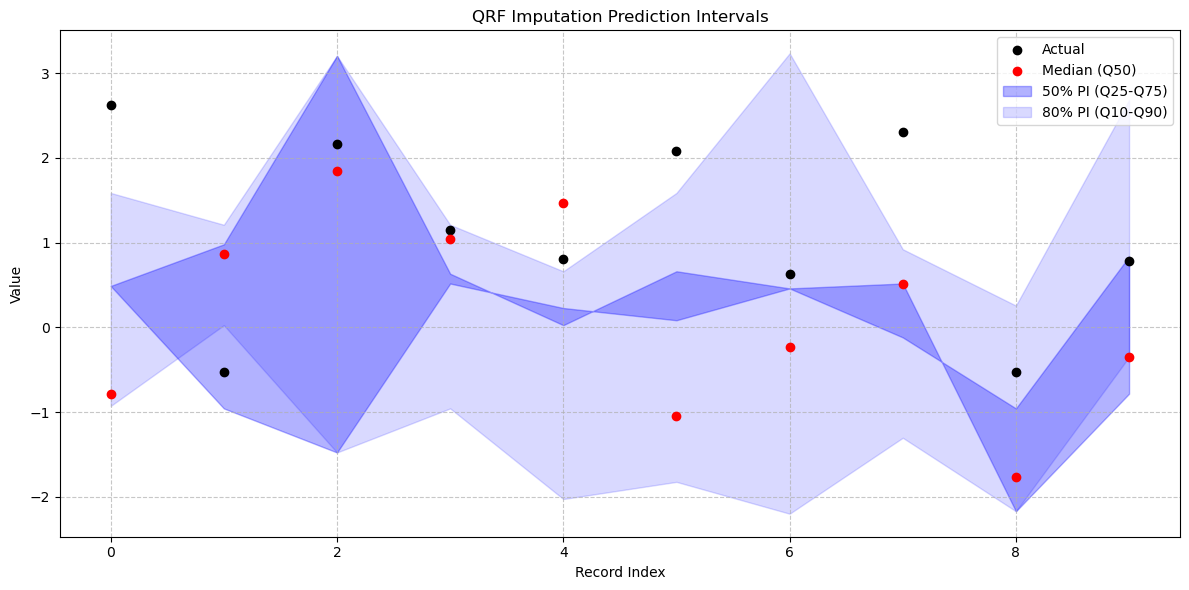

In [12]:
# Create a prediction interval plot for the first 10 records
plt.figure(figsize=(12, 6))

# Number of records to plot
n_records = 10

# X-axis positions
x = np.arange(n_records)

# Plot actual values
plt.scatter(
    x,
    actual_values.iloc[:n_records, 0],
    color="black",
    label="Actual",
    zorder=3,
)

# Plot median predictions
plt.scatter(
    x,
    imputed_values[0.5].iloc[:n_records, 0],
    color="red",
    label="Median (Q50)",
    zorder=3,
)

# Plot 50% prediction interval (Q25 to Q75)
plt.fill_between(
    x,
    imputed_values[0.3].iloc[:n_records, 0],
    imputed_values[0.7].iloc[:n_records, 0],
    alpha=0.3,
    color="blue",
    label="50% PI (Q25-Q75)",
)

# Plot 80% prediction interval (Q10 to Q90)
plt.fill_between(
    x,
    imputed_values[0.1].iloc[:n_records, 0],
    imputed_values[0.9].iloc[:n_records, 0],
    alpha=0.15,
    color="blue",
    label="80% PI (Q10-Q90)",
)

plt.xlabel("Record Index")
plt.ylabel("Value")
plt.title("QRF Imputation Prediction Intervals")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Assesing the method's performance

To check whether our model is overfitting and ensure robust results we can perform cross-validation and visualize the results.

In [14]:
# Run cross-validation on the same data set
qrf_results = cross_validate_model(
    QRF, diabetes_df, predictors, imputed_variables
)

qrf_results

,0.05,0.10,0.30,0.50,0.70,0.90,0.95
train,0.003480,0.006740,0.01373,0.012498,0.008909,0.006535,0.004148
test,0.004621,0.009479,0.02350,0.026368,0.022330,0.011269,0.005982


In [15]:
# Plot the results
plot_train_test_performance(qrf_results)

## Tuning the QRF model

The QRF imputer supports various parameters that can be adjusted to improve performance. More details coming soon.